In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

In [3]:
c0_m_s = 299792458
k_B = 1.380649e-23  # Boltzmann constant in J/K
h_J_Hz = 6.62607015e-34   # Planck's constant
m_per_ly = 9460730472580800

## Link Parameters
I am using a link range of 10 light years. For the transmit power, the Arecibo transmitter supposedly could go up to 1MW, but the 1974 message was [only 450 kW](https://en.wikipedia.org/wiki/Arecibo_message). The transmitter gain at 2380 MHz was 74 dBi, according to [the manual](https://www.naic.edu/~phil/hardware/xmiter430/430tx_manual_hagen.pdf) (see page 6). For now, we assume that the receive dish is identical to the transmit dish.

In [4]:
range_ly = 10    # Range of link

range_m = m_per_ly * range_ly

In [17]:
P_tx_W = 450e3 

f_Hz = 2380e6

G_tx_dB = 74 
λ_m = c0_m_s / f_Hz
P_tx_dBW = 10*np.log10(P_tx_W)
EIRP_dBW = P_tx_dBW + G_tx_dB

In [ ]:
L_dB = 20*np.log10(4 * np.pi * range_m / λ_m)   # Path Loss

In [7]:
# Assume an identical receive dish at the other end of the link
G_rx_dB = G_tx_dB

In [8]:
T = 300
Nₒ_W_Hz = k_B*T

## Interference from Solar radiation
This section computes the energy radiated by the Sun received by the antenna. It turns out to be negligible, but I thought it would have a significant effect since, obviously, the receive antenna could not resolve the transmitter from the Sun. Although solar radiation can interfere with satellite communication links, in this case it turns out to be negligible due to the significant path loss.

In [9]:
def plancks_law(f_Hz, T_K):
    return 2*h_J_Hz*f_Hz**3/c0_m_s**2 / (np.exp((h_J_Hz*f_Hz)/(k_B*T_K)) - 1)

Tsun_K = 5777
rsun_m = 700e6
#4*pi * 4*pi*rsun_m**2 * plancks_law(_f, Tsun_K)

# Very confused by this: Planck's law gives an answer in units of Watts/m**2/Sr. So we multiply by
# 4*pi*rsun**2, the surface area of the sun, to get an answer in units of Watts/Sr. I would expect
# that we would need to then multiply by 4*pi to get the total energy radiated in all directions.
# But multiplying instead by np.pi gets the integral to match the actual radiated energy of the sun.
#
# GOT IT! There is a cos(theta) factor in the integral, where theta is the angle between the surface normal and the direction
# of propagation. I haven't worked it out yet, but that is probably where the 1/4 factor is coming from relative to
# my naive approach.
def PSD_sun(f_Hz):
    return np.pi * 4*np.pi*rsun_m**2 * plancks_law(f_Hz, Tsun_K)

/var/folders/bt/g46v_mfn5_13w1xv9xz1d53w0000gn/T/ipykernel_74527/2178739708.py:2: RuntimeWarning: overflow encountered in exp
  return 2*h_J_Hz*f_Hz**3/c0_m_s**2 / (np.exp((h_J_Hz*f_Hz)/(k_B*T_K)) - 1)
/var/folders/bt/g46v_mfn5_13w1xv9xz1d53w0000gn/T/ipykernel_74527/4276688317.py:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, np.max(_f))


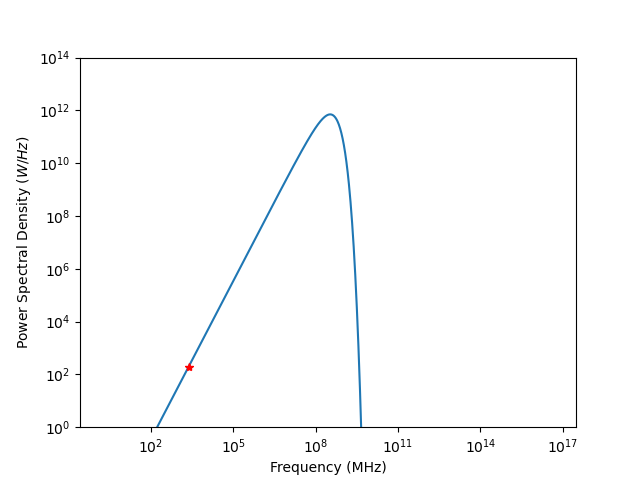

In [19]:
plt.figure()
_f = np.logspace(6,np.log10(c0_m_s/1e-9), 1000)
plt.plot(_f/1e6, PSD_sun(_f))
plt.plot(f_Hz/1e6, PSD_sun(f_Hz), 'r*')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0, np.max(_f))
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power Spectral Density ($W/Hz$)")
plt.ylim([1,1e14])
plt.show()

For a sanity check, let's compare the total output of the sun computed via two methods: (1) a numerical integration of the power spectral density function I computed above and (2) the [Stefan-Boltzmann law](https://en.wikipedia.org/wiki/Stefan%E2%80%93Boltzmann_law). The results match to about 1.26%, which seems good enough for my purposes.

In [21]:
from scipy import integrate

solar_output_integrated_W = integrate.quad(lambda f: PSD_sun(f), .001, c0_m_s/10e-9)[0]
solar_output_Stefan_Boltzmann_W =  5.6e-8*Tsun_K**4 * 4 * np.pi*rsun_m**2

print(f"integrated: {solar_output_integrated_W}")
print(f"Stefan-Boltzmann: {solar_output_Stefan_Boltzmann_W}")
print(f"Error: {100*(solar_output_integrated_W - solar_output_Stefan_Boltzmann_W)/(solar_output_Stefan_Boltzmann_W)}%")

integrated: 3.8889033588799806e+26
Stefan-Boltzmann: 3.8406385892345e+26
Error: 1.2566860568648486%


The whole solar noise calculation was a waste of time - at the receive antenna it is about 150 dB less than the thermal noise:

In [26]:
Nsun_dBW_Hz = 10*np.log10(PSD_sun(f_Hz)) - L_dB
Nsun_W_Hz = 10**(Nsun_dBW_Hz/10)

N_W_Hz = Nₒ_W_Hz + Nsun_W_Hz
N_dBW_Hz = 10*np.log10(N_W_Hz)

print(f"Solar interference PSD: {10*np.log10(Nsun_W_Hz)} dBW/Hz")
print(f"Thermal noise PSD: {10*np.log10(Nₒ_W_Hz)} dBW/Hz")

Solar interference PSD: -356.60901898850955 dBW/Hz
Thermal noise PSD: -203.82795462602104 dBW/Hz


In [29]:
P_N0_dBHz = EIRP_dBW - L_dB + G_rx_dB - N_dBW_Hz
C_bps = 10**(P_N0_dBHz/10) / np.log(2)
print(f"{C_bps:.1f} bits per second")

1110.2 bits per second


And there you have it: an Arecibo-to-Arecibo link over 10 light years has a capacity of over 1kbps. Note that since the link is power limited, the capacity scales with the square of the dish diameter. So if instead of a 300-m dish you used a 30-m dish, you would have a capacity of around 10 bps. This suggests to me that the a meaningful radio link in *Project Hail Mary* is not quite possible.